<a href="https://colab.research.google.com/github/MdMehedi-Hassan/RailTrack-Inspector-YOLO11x/blob/main/Rail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STEP 1: Install dependencies**

In [ ]:
!pip install -q albumentations opencv-python-headless matplotlib

# **STEP 2: Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

print("✅ Google Drive mounted.")
print("📁 Listing contents of /MyDrive/Datasets:")
!ls /content/drive/MyDrive/Datasets

Mounted at /content/drive
✅ Google Drive mounted.
📁 Listing contents of /MyDrive/Datasets:
data.yaml  Defects  Defects_Balanced  Test


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-3-b404583831d9>:53: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),


Original image counts: {'Fastener': 300, 'Bolt': 138, 'RailCrack': 46}

Class: Fastener
[✅] Generated 1000 augmented images for Fastener

Class: Bolt
[✅] Generated 1000 augmented images for Bolt

Class: RailCrack
[✅] Generated 1000 augmented images for RailCrack
Augmented image counts: {'Fastener': 1000, 'Bolt': 1000, 'RailCrack': 1000}


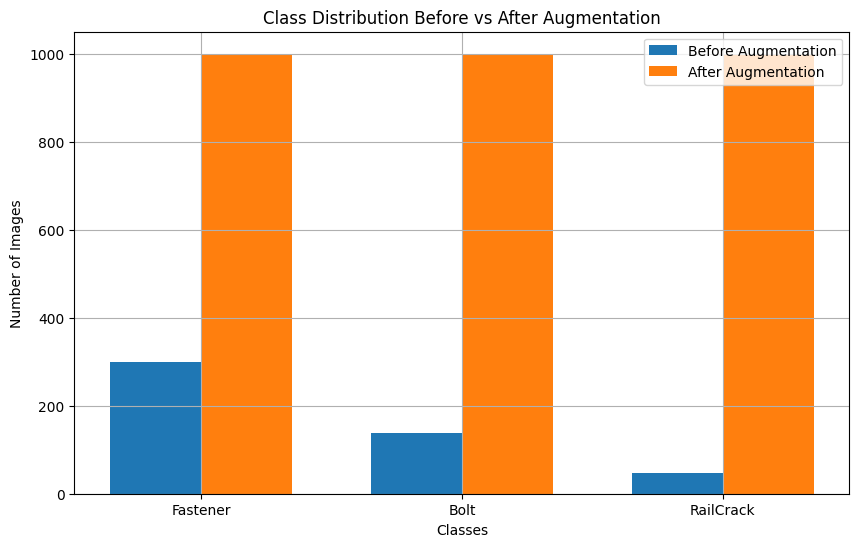

In [ ]:
# ==============================
# ✅ 1. SETUP
# ==============================
from google.colab import drive
drive.mount('/content/drive')


import os
import cv2
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from pathlib import Path
from collections import defaultdict

# === Constants ===
IMG_SIZE = 256

# === Google Drive paths (Change as needed) ===
base_dir = Path("/content/drive/MyDrive/Datasets/Defects")
output_dir = Path("/content/drive/MyDrive/Datasets/Defects_Balanced")

# Class and folder mapping
class_map = {
    'Fastener': 0,
    'Bolt': 1,
    'RailCrack': 2
}

subfolder_map = {
    'Fastener': 'fastener',
    'Bolt': 'bolt',
    'RailCrack': 'railcrack'
}

label_folder_map = {
    'Fastener': 'label',
    'Bolt': 'label',
    'RailCrack': 'label'
}

# === Augmentation pipeline ===
augmentor = A.Compose([
    A.Rotate(limit=45, p=0.7),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomScale(scale_limit=0.2, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.6),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.4),
    A.ToGray(p=0.1),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),
    A.MotionBlur(blur_limit=7, p=0.3),
    A.GaussianBlur(blur_limit=7, p=0.2),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

# ==============================
# ✅ 2. DATA FUNCTIONS
# ==============================
def get_data_info():
    counts = defaultdict(int)
    img_paths = defaultdict(list)
    label_paths = defaultdict(list)

    for cls in class_map.keys():
        img_dir = base_dir / cls / subfolder_map[cls]
        lbl_dir = base_dir / cls / label_folder_map[cls]

        if not img_dir.exists() or not lbl_dir.exists():
            print(f"[Warning] Missing folder for class {cls}")
            continue

        for img_file in os.listdir(img_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                name = Path(img_file).stem
                label_file = name + ".txt"
                label_path = lbl_dir / label_file
                if label_path.exists():
                    counts[cls] += 1
                    img_paths[cls].append(str(img_dir / img_file))
                    label_paths[cls].append(str(label_path))
                else:
                    print(f"[Warning] Missing label for image {img_file} in class {cls}")
    return counts, img_paths, label_paths

# ==============================
# ✅ 3. AUGMENTATION FUNCTION
# ==============================
def augment_dataset(target_count=1000):
    _, img_paths, label_paths = get_data_info()

    for cls in class_map.keys():
        print(f"\nClass: {cls}")
        out_img_dir = output_dir / cls / "images"
        out_lbl_dir = output_dir / cls / "labels"

        # Clear output folders (optional but ensures cleanliness)
        if out_img_dir.exists():
            shutil.rmtree(out_img_dir)
        if out_lbl_dir.exists():
            shutil.rmtree(out_lbl_dir)
        out_img_dir.mkdir(parents=True, exist_ok=True)
        out_lbl_dir.mkdir(parents=True, exist_ok=True)

        current_img_paths = img_paths[cls]
        current_lbl_paths = label_paths[cls]

        if len(current_img_paths) == 0:
            print(f"[❌] No original images found for {cls}. Skipping.")
            continue

        aug_count = 0
        while aug_count < target_count:
            idx = random.randint(0, len(current_img_paths) - 1)
            img_path = current_img_paths[idx]
            label_path = current_lbl_paths[idx]

            img = cv2.imread(img_path)
            if img is None:
                print(f"[⚠️] Could not read image: {img_path}")
                continue

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            augmented = augmentor(image=img)['image']

            aug_img_name = f"{cls}_aug_{aug_count}.jpg"
            aug_lbl_name = f"{cls}_aug_{aug_count}.txt"

            cv2.imwrite(str(out_img_dir / aug_img_name), augmented)
            shutil.copyfile(label_path, out_lbl_dir / aug_lbl_name)

            aug_count += 1

        print(f"[✅] Generated {target_count} augmented images for {cls}")

# ==============================
# ✅ 4. COUNT + PLOT FUNCTIONS
# ==============================
def count_augmented_images():
    counts = defaultdict(int)
    for cls in class_map.keys():
        img_dir = output_dir / cls / "images"
        if img_dir.exists():
            counts[cls] = len([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
    return counts

def plot_distributions(before_counts, after_counts):
    labels = list(class_map.keys())
    before_vals = [before_counts.get(cls, 0) for cls in labels]
    after_vals = [after_counts.get(cls, 0) for cls in labels]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(x - width/2, before_vals, width, label='Before Augmentation')
    ax.bar(x + width/2, after_vals, width, label='After Augmentation')

    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of Images')
    ax.set_title('Class Distribution Before vs After Augmentation')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.grid(True)
    plt.show()

# ==============================
# ✅ 5. RUN EVERYTHING
# ==============================
original_counts, _, _ = get_data_info()
print("Original image counts:", dict(original_counts))

augment_dataset(target_count=1000)

augmented_counts = count_augmented_images()
print("Augmented image counts:", dict(augmented_counts))

plot_distributions(original_counts, augmented_counts)

#**Sample Images**

In [ ]:
from pathlib import Path

# Base paths
original_base = Path("/content/drive/MyDrive/Datasets/Defects")
augmented_base = Path("/content/drive/MyDrive/Datasets/Defects_Balanced")

# Class and subfolder mapping
classes = {
    'Fastener': 'fastener',
    'Bolt': 'bolt',
    'RailCrack': 'railcrack'
}


<ipython-input-6-931fd2b2d990>:46: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


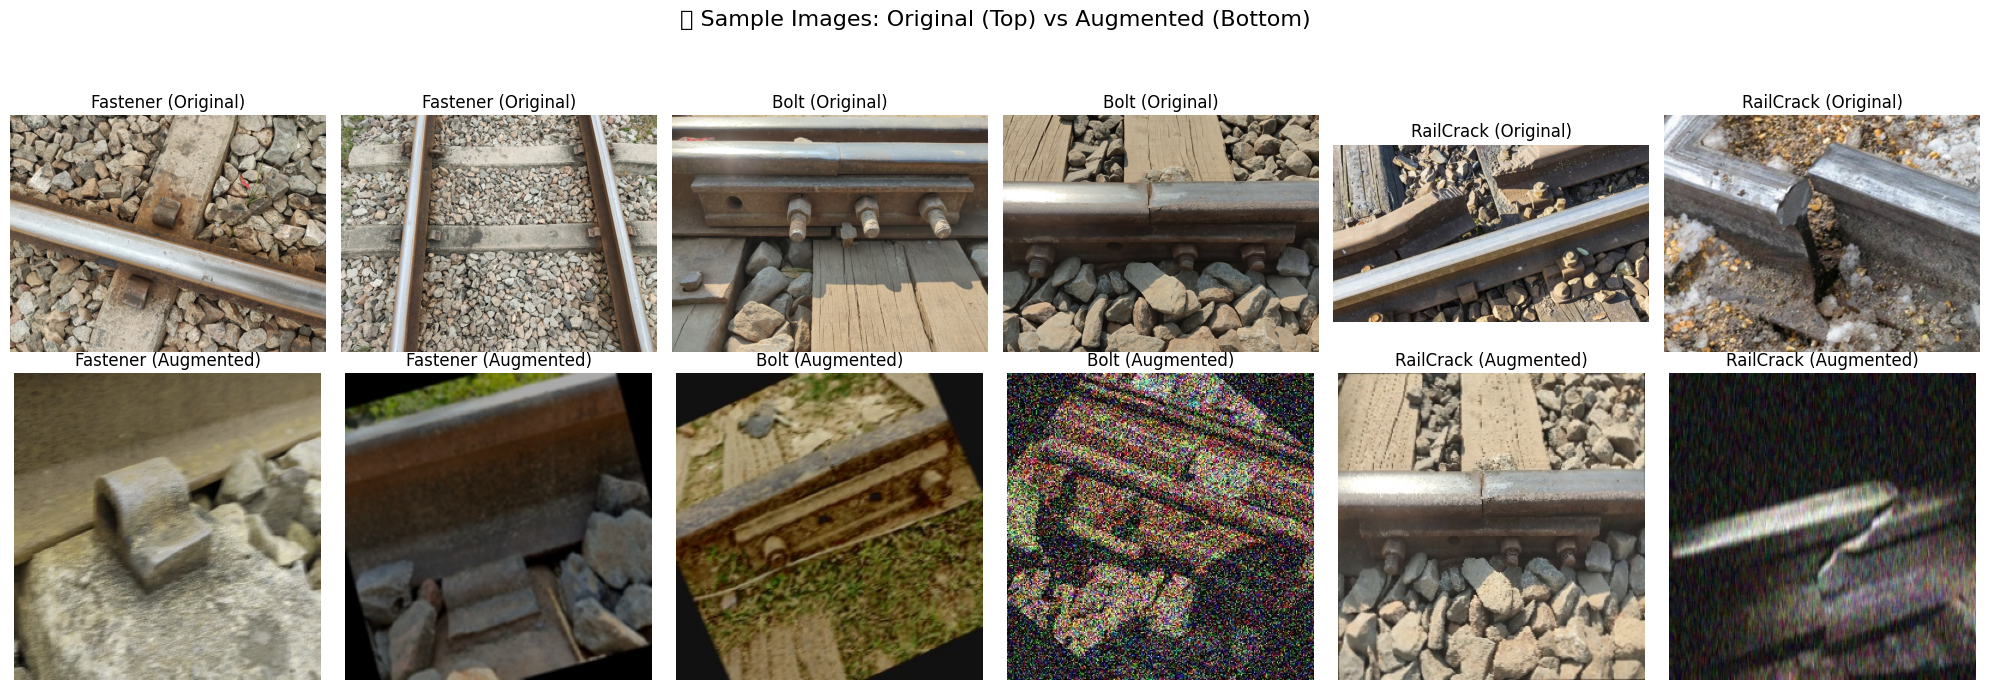

In [ ]:
def get_random_images(base_path, subfolder_key, count=2, is_augmented=False):
    """
    Returns a list of random image file paths from a given class folder
    """
    if is_augmented:
        img_dir = base_path / subfolder_key / "images"
    else:
        img_dir = base_path / subfolder_key / classes[subfolder_key]

    image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    if len(image_files) < count:
        raise ValueError(f"Not enough images in {img_dir} to sample {count}")

    selected = random.sample(image_files, count)
    return [img_dir / img for img in selected]

def display_sample_images():
    fig, axes = plt.subplots(2, 6, figsize=(20, 7))
    fig.suptitle("🔍 Sample Images: Original (Top) vs Augmented (Bottom)", fontsize=16)

    all_classes = list(classes.keys())
    for i, cls in enumerate(all_classes):
        # Get 2 original + 2 augmented images
        orig_imgs = get_random_images(original_base, cls, count=2)
        aug_imgs = get_random_images(augmented_base, cls, count=2, is_augmented=True)

        for j in range(2):
            # Top row: Original
            img = cv2.imread(str(orig_imgs[j]))
            if img is not None:
                axes[0, i * 2 + j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                axes[0, i * 2 + j].set_title(f"{cls} (Original)")
            else:
                axes[0, i * 2 + j].set_title("Read Error")
            axes[0, i * 2 + j].axis("off")

            # Bottom row: Augmented
            img = cv2.imread(str(aug_imgs[j]))
            if img is not None:
                axes[1, i * 2 + j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                axes[1, i * 2 + j].set_title(f"{cls} (Augmented)")
            else:
                axes[1, i * 2 + j].set_title("Read Error")
            axes[1, i * 2 + j].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Run it
display_sample_images()

#**Model Training Begins**

#**Install Dependencies**

In [ ]:
# Install YOLOv11 library (replace with correct repo if available)
!pip install ultralytics opencv-python-headless matplotlib numpy torch

# Verify installation
import ultralytics
print("Ultralytics version:", ultralytics.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

**Load YOLOv11 Model**

In [ ]:
from ultralytics import YOLO

# Load YOLO11 model
model = YOLO('yolo11x.pt')

100%|██████████| 109M/109M [00:00<00:00, 417MB/s] 


**Prepare Your Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Model Training**

In [ ]:
results = model.train(
    data='/content/drive/MyDrive/Datasets/data.yaml',  # Path to dataset YAML
    epochs=10,
    imgsz=256,
    batch=16,
    workers=2,
    name='railway_defect_detection',
    project='/content/drive/MyDrive/runs'  # Save runs in Google Drive
)

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Datasets/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=railway_defect_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, 

100%|██████████| 755k/755k [00:00<00:00, 22.8MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              


  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  8                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  9                  -1  1   1476864  ultralytics.nn.modules.block.SPPF            [768, 768, 5]                 
 10                  -1  2   3264768  ultralytics.nn.modules.block.C2PSA           [768, 768, 2]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  2   5612544  ultralytics.nn.modules.block.C3k2            [1536, 768, 2, True]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None

100%|██████████| 5.35M/5.35M [00:00<00:00, 107MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.1 ms, read: 5.0±3.9 MB/s, size: 4641.7 KB)


train: Scanning /content/drive/MyDrive/Datasets/Defects/Bolt/bolt.cache... 0 images, 484 backgrounds, 0 corrupt: 100%|██████████| 484/484 [00:00<?, ?it/s]

WARNING ⚠️ Labels are missing or empty in /content/drive/MyDrive/Datasets/Defects/Bolt/bolt.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 0.1±0.0 MB/s, size: 41.0 KB)


val: Scanning /content/drive/MyDrive/Datasets/Defects_Balanced/Bolt/labels.cache... 3000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3000/3000 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/runs/railway_defect_detection/labels.jpg... 
WARNING ⚠️ zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/runs/railway_defect_detection
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.52G          0      25.82          0          0        256: 100%|██████████| 31/31 [03:12<00:00,  6.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [05:04<00:00,  3.24s/it]


                   all       3000       3826   0.000145     0.0447   8.72e-05      3e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.25G          0      2.005          0          0        256: 100%|██████████| 31/31 [00:23<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:11<00:00,  8.07it/s]

                   all       3000       3826          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.25G          0     0.1802          0          0        256: 100%|██████████| 31/31 [00:29<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:16<00:00,  5.70it/s]


                   all       3000       3826   9.23e-05    0.00385   8.88e-05   1.35e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.36G          0   0.008905          0          0        256: 100%|██████████| 31/31 [00:27<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:11<00:00,  8.03it/s]

                   all       3000       3826          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.36G          0  6.276e-06          0          0        256: 100%|██████████| 31/31 [00:27<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:11<00:00,  8.13it/s]

                   all       3000       3826          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.36G          0          0          0          0        256: 100%|██████████| 31/31 [00:27<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:11<00:00,  8.13it/s]

                   all       3000       3826          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.64G          0          0          0          0        256: 100%|██████████| 31/31 [00:27<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:11<00:00,  8.02it/s]

                   all       3000       3826          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.64G          0          0          0          0        256: 100%|██████████| 31/31 [00:27<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:11<00:00,  8.10it/s]

                   all       3000       3826          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.64G          0          0          0          0        256: 100%|██████████| 31/31 [00:28<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:11<00:00,  8.15it/s]

                   all       3000       3826          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.64G          0          0          0          0        256: 100%|██████████| 31/31 [00:25<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:11<00:00,  8.15it/s]

                   all       3000       3826          0          0          0          0



10 epochs completed in 0.243 hours.
Optimizer stripped from /content/drive/MyDrive/runs/railway_defect_detection/weights/last.pt, 114.3MB
Optimizer stripped from /content/drive/MyDrive/runs/railway_defect_detection/weights/best.pt, 114.3MB

Validating /content/drive/MyDrive/runs/railway_defect_detection/weights/best.pt...
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11x summary (fused): 190 layers, 56,830,489 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [01:14<00:00,  1.26it/s]


                   all       3000       3826   0.000143     0.0436   8.57e-05   2.83e-05
              Fastener       1000       1231   0.000292      0.127   0.000205   5.18e-05
                  Bolt       1059       1391          0          0          0          0
             RailCrack       1028       1204   0.000137    0.00415   5.18e-05   3.32e-05
Speed: 0.0ms preprocess, 2.0ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /content/drive/MyDrive/runs/railway_defect_detection


**Confusion Matrix and Confusion Matrix Normalized**

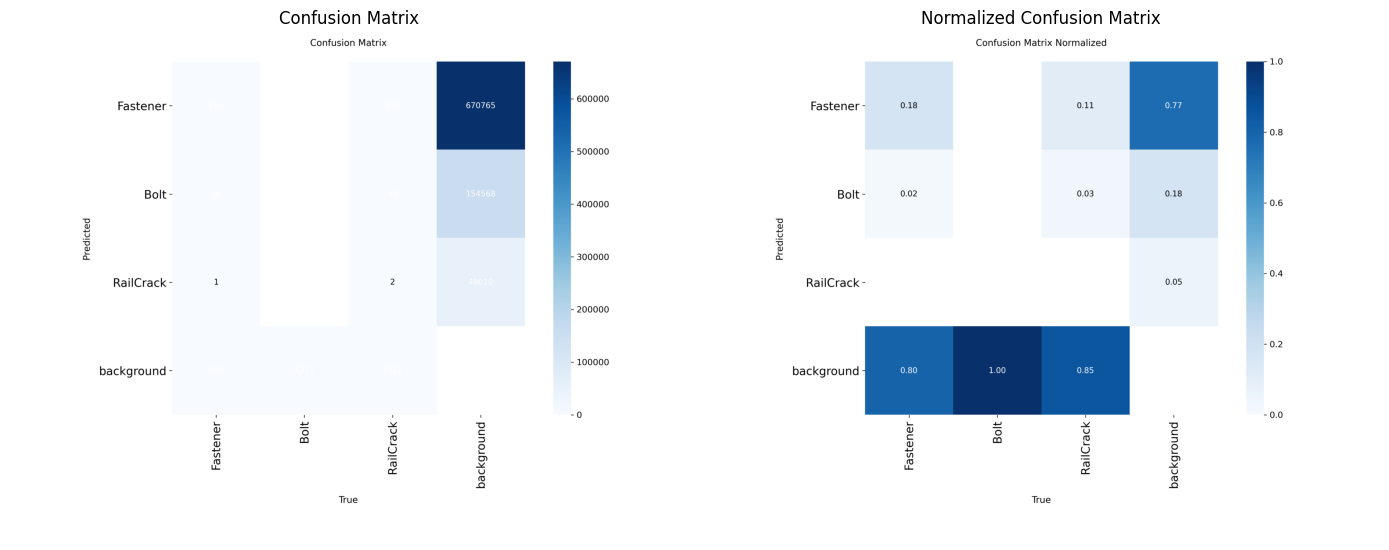

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load images
conf_matrix_img = cv2.imread('/content/drive/MyDrive/runs/railway_defect_detection/confusion_matrix.png')
conf_matrix_norm_img = cv2.imread('/content/drive/MyDrive/runs/railway_defect_detection/confusion_matrix_normalized.png')

# Convert BGR to RGB (for matplotlib)
conf_matrix_img = cv2.cvtColor(conf_matrix_img, cv2.COLOR_BGR2RGB)
conf_matrix_norm_img = cv2.cvtColor(conf_matrix_norm_img, cv2.COLOR_BGR2RGB)

# Plot side by side
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(conf_matrix_img)
plt.title("Confusion Matrix")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(conf_matrix_norm_img)
plt.title("Normalized Confusion Matrix")
plt.axis('off')

plt.tight_layout()
plt.show()

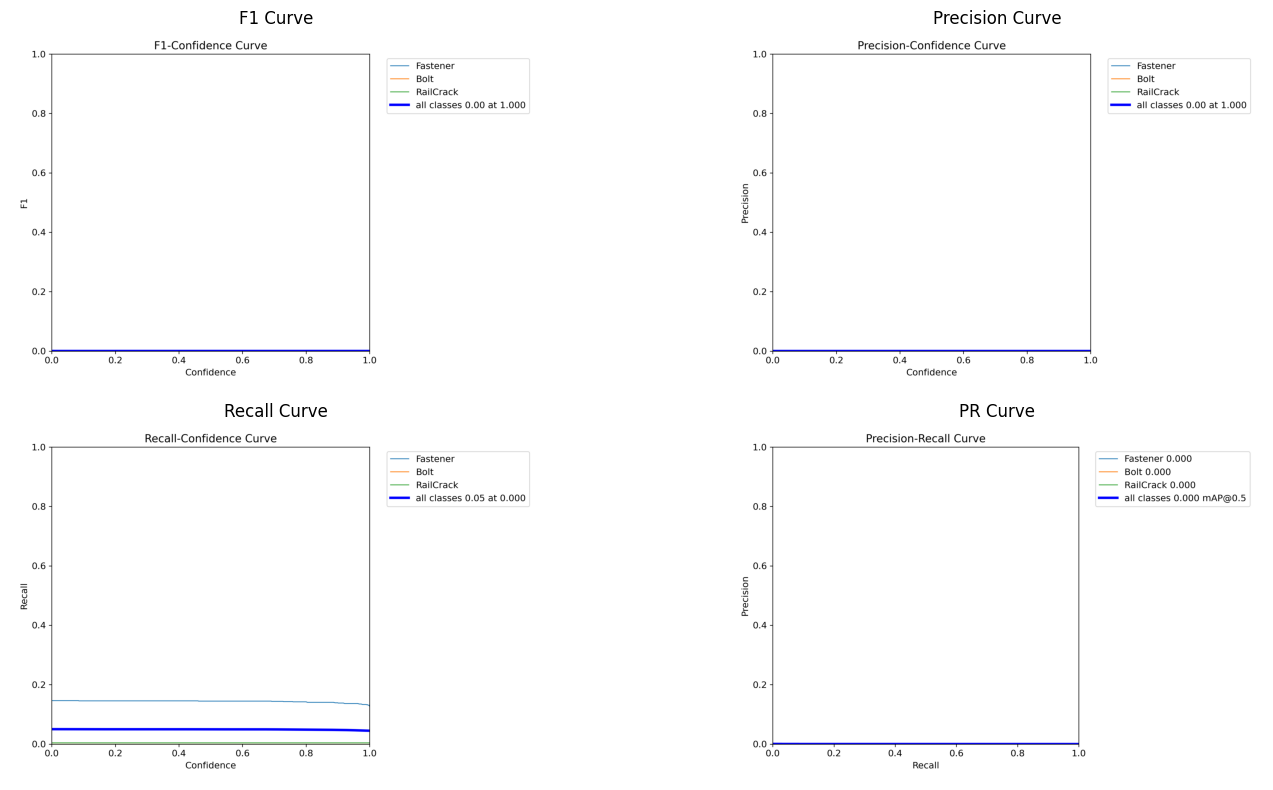

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Base directory
base_dir = "/content/drive/MyDrive/runs/railway_defect_detection"

# Metrics to display
files = {
    "F1 Curve": "F1_curve.png",
    "Precision Curve": "P_curve.png",
    "Recall Curve": "R_curve.png",
    "PR Curve": "PR_curve.png"
}

# Plot all
plt.figure(figsize=(16, 8))
for idx, (title, filename) in enumerate(files.items(), 1):
    img_path = f"{base_dir}/{filename}"
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Could not load {filename}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, idx)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

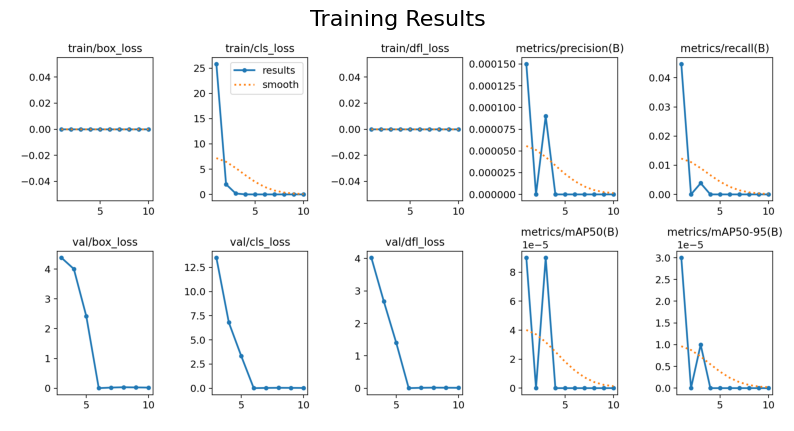

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Path to results.png
img_path = "/content/drive/MyDrive/runs/railway_defect_detection/results.png"

# Load and convert image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title("Training Results", fontsize=16)
plt.axis('off')
plt.show()

In [ ]:
from ultralytics import YOLO

# Path to your best weights
weights_path = "/content/drive/MyDrive/runs/railway_defect_detection/weights/best.pt"

# Load the model
model = YOLO(weights_path)

In [ ]:
import os

# Path to your test images folder
test_img_folder = "/content/drive/MyDrive/Datasets/Test"

# Run prediction
results = model.predict(source=test_img_folder, conf=0.25, save=False)

# Folder to save prediction images
save_dir = "/content/drive/MyDrive/runs/inference_results"
os.makedirs(save_dir, exist_ok=True)

# Save predictions
for i, r in enumerate(results):
    r.save(filename=os.path.join(save_dir, f"result_{i}.jpg"))



image 1/20 /content/drive/MyDrive/Datasets/Test/IMG_20250512_144340.jpg: 640x480 (no detections), 82.1ms
image 2/20 /content/drive/MyDrive/Datasets/Test/IMG_20250512_144357.jpg: 640x480 (no detections), 20.5ms
image 3/20 /content/drive/MyDrive/Datasets/Test/IMG_20250512_144425.jpg: 640x480 (no detections), 20.6ms
image 4/20 /content/drive/MyDrive/Datasets/Test/IMG_20250512_144438.jpg: 640x480 (no detections), 20.8ms
image 5/20 /content/drive/MyDrive/Datasets/Test/IMG_20250512_144453.jpg: 640x480 (no detections), 20.4ms
image 6/20 /content/drive/MyDrive/Datasets/Test/IMG_20250512_144510.jpg: 640x480 (no detections), 20.5ms
image 7/20 /content/drive/MyDrive/Datasets/Test/IMG_20250512_144528.jpg: 640x480 (no detections), 20.5ms
image 8/20 /content/drive/MyDrive/Datasets/Test/IMG_20250512_144607.jpg: 640x480 (no detections), 20.5ms
image 9/20 /content/drive/MyDrive/Datasets/Test/IMG_20250512_144738.jpg: 480x640 (no detections), 80.2ms
image 10/20 /content/drive/MyDrive/Datasets/Test/IMG_2